以下のコンペについて、調査した内容を整理する。
# [Real or Not? NLP with Disaster Tweets](https://www.kaggle.com/c/nlp-getting-started)

## コンペについて
Twitterを緊急時の重要なコミュニケーションツールとして、人々が災害を発信しているかどうか監視することに関心を持つ機関（災害救援機関や報道機関など）が増えている、という背景で開催されている。下記画像のように、「ABLAZE(燃え上がることを指す形容詞)」という言葉は比喩的表現である。人間にはその意味がすぐに理解できる(視覚的補助があればより明確になる)が、機械にとっては判別が難しい。\
自然言語処理(Natural Language Proccessing)のデータ分析入門者のためのコンペ。多くのNLP入門者がこのコンペを訪れる。
<img src="https://storage.googleapis.com/kaggle-media/competitions/tweet_screenshot.png" width="300">

#### なぜこのコンペを選択したか
NLPに興味があるから。

## データについて
- 説明変数
  - id:各ツイートの一意の識別子
  - text:ツイートのテキスト
  - location:ツイートの送信元の場所（空白の場合があります）
  - keyword:ツイートの特定のキーワード（空白の場合があります）(※"accident"や"aftershock"など、ツイート中に含まれる災害かどうかを判断できそうな単語)
- 目的変数
  - terget:本当に災害かどうかの識別子。1が災害。0が災害ではない。
  
用意されているデータは全て英語。  
  
## 評価について
予測値とラベルとの$F_1$値で判定する。

データの提出形式は以下の通り。
```
id,target
0,0
2,0
3,1
9,0
11,0
```

## 参照したノートブック
### [NLP Getting Started Tutorial](https://www.kaggle.com/philculliton/nlp-getting-started-tutorial)

#### なぜこのノートブックを選択したか
NLPにおける機械学習は、近年はニューラルネットワーク(NN)を使用することが殆どである。\
カリキュラムでNNを扱わないうちにNNを用いないNLPの知見を高めたく、このノートブックはNNを用いずにモデルを作成・評価しているため。また、このノートブックの最終的な指標値が高く(コメントでそのように書いている人が多かった)、何かの参考になるかと思ったため。

以下、コード部分はほぼノートブックのコピペ。

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn import feature_extraction, linear_model, model_selection, preprocessing

In [2]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

内容を一部確認

In [13]:
import pprint

pprint.pprint(list(train_df[train_df["target"] == 0]["text"].values[0:10]))

["What's up man?",
 'I love fruits',
 'Summer is lovely',
 'My car is so fast',
 'What a goooooooaaaaaal!!!!!!',
 'this is ridiculous....',
 'London is cool ;)',
 'Love skiing',
 'What a wonderful day!',
 'LOOOOOOL']


In [14]:
pprint.pprint(list(train_df[train_df["target"] == 1]["text"].values[0:10]))

['Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all',
 'Forest fire near La Ronge Sask. Canada',
 "All residents asked to 'shelter in place' are being notified by officers. No "
 'other evacuation or shelter in place orders are expected',
 '13,000 people receive #wildfires evacuation orders in California ',
 'Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours '
 'into a school ',
 '#RockyFire Update => California Hwy. 20 closed in both directions due to '
 'Lake County fire - #CAfire #wildfires',
 '#flood #disaster Heavy rain causes flash flooding of streets in Manitou, '
 'Colorado Springs areas',
 "I'm on top of the hill and I can see a fire in the woods...",
 "There's an emergency evacuation happening now in the building across the "
 'street',
 "I'm afraid that the tornado is coming to our area..."]


ノートブックで作成するモデルの理論としては、ツイート中に含まれる単語が実際の災害に関するものかを示すかどうかを指標とする。\
完全に正しいものではないが、開始の第一歩としては良いと述べている。

scikit-learnのCountVectorizerを使用して、各ツイートの単語をカウントして機械学習モデルが処理できるデータ(ベクトル)に変換する。\
変換されたベクトルは"Bag of Words"と呼ばれる。

In [15]:
count_vectorizer = feature_extraction.text.CountVectorizer()

## let's get counts for the first 5 tweets in the data
example_train_vectors = count_vectorizer.fit_transform(train_df["text"][0:5])

## we use .todense() here because these vectors are "sparse" (only non-zero elements are kept to save space)
print(example_train_vectors[0].todense().shape)
print(example_train_vectors[0].todense())

(1, 54)
[[0 0 0 1 1 1 0 0 0 0 0 0 1 1 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 1 0
  0 0 0 1 0 0 0 0 0 0 0 0 0 1 1 0 1 0]]


最初の5つのツイートには54のユニークな単語（または「トークン」）があることを示している。
最初のツイートには、これらの一意のトークンの一部のみが含まれている。ゼロの部分はすべて、最初以外のツイートに存在するトークンである。

全てのツイートについて変換する。

In [31]:
train_vectors = count_vectorizer.fit_transform(train_df["text"])

## note that we're NOT using .fit_transform() here. Using just .transform() makes sure
# that the tokens in the train vectors are the only ones mapped to the test vectors - 
# i.e. that the train and test vectors use the same set of tokens.
test_vectors = count_vectorizer.transform(test_df["text"])
print(train_vectors[0].todense().shape)
print(test_vectors[0].todense().shape)

(1, 21637)
(1, 21637)


ツイート内の特定の単語（または単語のセット）の存在は、そのツイートが本当に災害であるかどうかに直接リンクする場合がある。\
これを線形接続と仮定し、線形モデルを作成してみる。\
使用するモデルは以下。

[sklearn.linear_model.RidgeClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeClassifier.html)

In [18]:
## Our vectors are really big, so we want to push our model's weights
## toward 0 without completely discounting different words - ridge regression 
## is a good way to do this.
clf = linear_model.RidgeClassifier()

クロスバリデーション(CV)を用いてテストをする。ノートブックでは3回のCVを実施している。

In [22]:
scores = model_selection.cross_val_score(clf, train_vectors, train_df["target"], cv=3, scoring="f1")
scores

array([0.59421842, 0.56455572, 0.64149093])

0.65はノートブックによると悪くない値らしい。\
改善方法としてはTFIDF、LSA、LSTM / RNNなどが挙げられると書いてある。

各単語について調べる。
- TFIDF:"Term Frequency / Inverse Document Frequency"の略で、副詞など、文中に当たり前に出てくる語の頻度の偏りによる分析のずれを解消するための、Bag of Wordsの改良版。
- LSA:"Latent Semantic Analysis"の略で、潜在的意味解析の意。単語ごとに意味的な分類分けをすることで次元削減ができる。
- LSTM / RNN:Long Short Term Memory / Reccurent Neural Networkの略。深層学習の話です（雑）。

以下はノートブックのモデルを真似した。

In [34]:
clf_2 = linear_model.RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
                                     max_iter=None, normalize=False, random_state=None,
                                     solver='auto', tol=0.001)

In [28]:
scores = model_selection.cross_val_score(clf_2, train_vectors, train_df["target"], cv=3, scoring="f1")
scores

array([0.59421842, 0.56455572, 0.64149093])

In [29]:
clf_2.fit(train_vectors, train_df["target"])

RidgeClassifier()

In [30]:
sample_submission = pd.read_csv("sample_submission.csv")
sample_submission["target"] = clf_2.predict(test_vectors)
sample_submission.head()
sample_submission.to_csv("submission.csv", index=False)

ノートブックは結果をcsv化して提出して終わりとなる。\
試しにTFIDFで学習させてCVしてみる。\
変換器はsklearnに用意されている。

[sklearn.feature_extraction.text.TfidfVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html)

In [32]:
tfidf_vectorizer = feature_extraction.text.TfidfVectorizer()

train_vectors_tfidf = tfidf_vectorizer.fit_transform(train_df["text"])
test_vectors_tfidf = tfidf_vectorizer.transform(test_df["text"])

print(train_vectors_tfidf[0].todense().shape)
print(test_vectors_tfidf[0].todense().shape)

(1, 21637)
(1, 21637)


In [56]:
scores = model_selection.cross_val_score(clf_2, train_vectors_tfidf, train_df["target"], cv=3, scoring="f1")
scores

array([0.63366337, 0.6122449 , 0.68442211])

スコアが4ポイントほど上がった。モデルの仕組みを分かってないので考察が出来ない。\
とりあえず、LSAも試してみる。削減後の次元数も何パターンか試してみる。

In [53]:
# 元データの次元数を確認
train_vectors.shape

(7613, 21637)

In [58]:
from sklearn.decomposition import TruncatedSVD

# 区切りはテキトーです
list_dimension = [2, 5, 10, 30, 50, 100, 150, 200, 300, 400, 500, 1000, 1500, 2000, 3000, 5000, 10000]

list_score = []
for dimension in list_dimension:

    # n_componentsに削減後の次元数を指定
    svd = TruncatedSVD(n_components=dimension, random_state=42)
    svd.fit(train_vectors)

    decomposed_features = svd.transform(train_vectors)

    scores = model_selection.cross_val_score(clf_2, decomposed_features, train_df["target"], cv=3, scoring="f1")
    list_score.append(scores.max())
    
    # CVの結果は最大値のみ表示
    print("dimension:{} score(MAX):{}".format(dimension, scores.max()))

dimension:2 score(MAX):0.46949891067538124
dimension:5 score(MAX):0.5109170305676856
dimension:10 score(MAX):0.5643410852713179
dimension:30 score(MAX):0.6314285714285715
dimension:50 score(MAX):0.6154598825831703
dimension:100 score(MAX):0.6531850353892821
dimension:150 score(MAX):0.6546577457539886
dimension:200 score(MAX):0.6352201257861635
dimension:300 score(MAX):0.6965725806451613
dimension:400 score(MAX):0.6745796241345203
dimension:500 score(MAX):0.6242587601078168
dimension:1000 score(MAX):0.6525708793849111
dimension:1500 score(MAX):0.6132075471698114
dimension:2000 score(MAX):0.6279707495429616
dimension:3000 score(MAX):0.5794481446241675
dimension:5000 score(MAX):0.6078998073217726
dimension:10000 score(MAX):0.6408243375858684


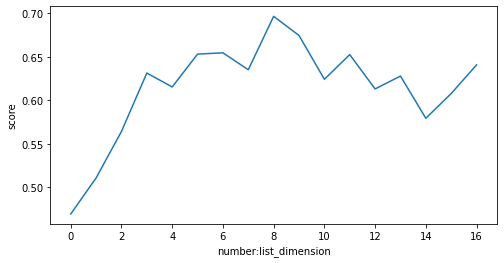

In [69]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(8, 4))
plt.xlabel("number:list_dimension")
plt.ylabel("score")
x = range(len(list_score))
plt.plot(x, list_score)

plt.show()

設定するのにちょうどよい次元数があるかもしれない。\
1000あたりから処理時間が長くなってくる。

In [70]:
# 100から500の間でもう一度
list_dimension_2 = range(100, 500, 50)

list_score_2 = []
for dimension in list_dimension_2:

    # n_componentsに削減後の次元数を指定
    svd = TruncatedSVD(n_components=dimension, random_state=42)

    decomposed_features = svd.fit_transform(train_vectors)

    scores = model_selection.cross_val_score(clf_2, decomposed_features, train_df["target"], cv=3, scoring="f1")
    list_score_2.append(scores.max())
    
    # CVの結果は最大値のみ表示
    print("dimension:{} score(MAX):{}".format(dimension, scores.max()))

dimension:100 score(MAX):0.6531850353892821
dimension:150 score(MAX):0.6546577457539886
dimension:200 score(MAX):0.6352201257861635
dimension:250 score(MAX):0.6442105263157895
dimension:300 score(MAX):0.6965725806451613
dimension:350 score(MAX):0.6929870129870129
dimension:400 score(MAX):0.6745796241345203
dimension:450 score(MAX):0.6650222002960039


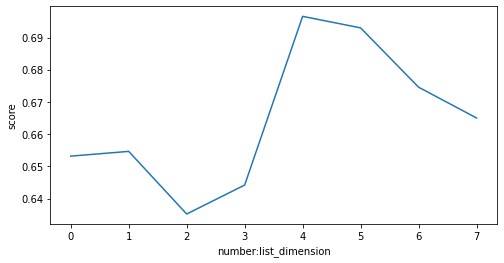

In [71]:
plt.figure(figsize=(8, 4))
plt.xlabel("number:list_dimension")
plt.ylabel("score")
x = range(len(list_score_2))
plt.plot(x, list_score_2)

plt.show()

In [72]:
# 250から350の間でもう一度
list_dimension_3 = range(250, 350, 10)

list_score_3 = []
for dimension in list_dimension_3:

    # n_componentsに削減後の次元数を指定
    svd = TruncatedSVD(n_components=dimension, random_state=42)

    decomposed_features = svd.fit_transform(train_vectors)

    scores = model_selection.cross_val_score(clf_2, decomposed_features, train_df["target"], cv=3, scoring="f1")
    list_score_3.append(scores.max())
    
    # CVの結果は最大値のみ表示
    print("dimension:{} score(MAX):{}".format(dimension, scores.max()))

dimension:250 score(MAX):0.6442105263157895
dimension:260 score(MAX):0.6635367762128325
dimension:270 score(MAX):0.6928972917731221
dimension:280 score(MAX):0.6937119675456389
dimension:290 score(MAX):0.6774025974025975
dimension:300 score(MAX):0.6965725806451613
dimension:310 score(MAX):0.6932515337423312
dimension:320 score(MAX):0.6939807789580172
dimension:330 score(MAX):0.6926582278481014
dimension:340 score(MAX):0.6473684210526315


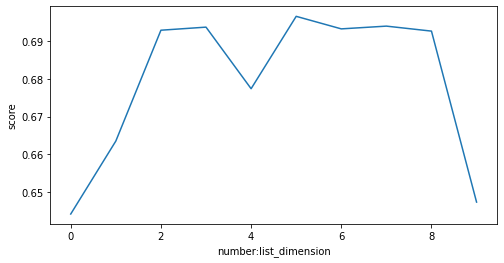

In [73]:
plt.figure(figsize=(8, 4))
plt.xlabel("number:list_dimension")
plt.ylabel("score")
x = range(len(list_score_3))
plt.plot(x, list_score_3)

plt.show()

次元数の削減は大体で良さそうかもしれない。データによるのかもしれないが、頭打ちになる。\
今回、最も性能が良かった次元数300でテストデータを変換し、Kaggleに提出して終わる。

In [78]:
svd = TruncatedSVD(n_components=300, random_state=42)
decomposed_features_train = svd.fit_transform(train_vectors)
decomposed_features_test = svd.transform(test_vectors)

clf_2.fit(decomposed_features_train, train_df["target"])

sample_submission = pd.read_csv("sample_submission.csv")
sample_submission["target"] = clf_2.predict(decomposed_features_test)
sample_submission.head()
sample_submission.to_csv("submission_2.csv", index=False)

##### 結果
- score:0.77781
- 順位:1218/1559

上位70人ほどのスコアは1.0。完全に分類できる問題らしい。

##### 考察
- 今回は説明変数として"text"のみを使用した。他の説明変数と合わせて学習・検証するためには、やはりNNでモデル構築をしなければならないのかと考えている(次元削減しても次元数が多すぎるため、他の特徴量がむしろノイズにならないかを懸念)。
- NNを使用しないならば、ルールベースでtextから単語を抽出してラベリングすれば新しい特徴量が生成できると思うので、それをもとに学習・検証しても良さそう。(NNを優先して試したいので、今は実施する予定は無い)
- 文章を特徴量とするデータについて、機械学習の結果としてラベル付を行ったものを新たな特徴量として機械学習を行う場合、ラベル付を行うモデルの制度としてはどのくらいの性能が求められるのだろうか。

#### 今回使用したRidgeClassifierについて
参考記事→[リッジ回帰とラッソ回帰の理論と実装を初めから丁寧に](https://qiita.com/Takayoshi_Makabe/items/8f6dcb25124b9dcb1ae8)

重回帰分析では損失関数に最小二乗法を用いているが、損失関数に正則化項として回帰係数(重み)の$L_2$ノルムの二乗にハイパーパラメータをかけたものを加えたものをリッジ回帰と呼ぶ。$L_1$ノルムだとラッソ回帰と呼ばれる。

損失関数が他のモデルと異なるだけのことであれば、今回の場合だと他の線形モデルで色々試してみても良いかもしれない。